# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 800

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    800
ID           800
Time         800
none         800
username     800
Text         800
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['If ever there was a time when I wanted to rip my nose off of my face and throw it FAR, that time is NOW!! Running out of tissues ',
       "Went to the doctor, got some meds for the pain.. Hoping they work so I don't have to take x-rays.. Dreading going to work today.. ",
       'Everywhere I look...happy pregnant people. I miss my midwife ',
       '62 was the age my grandmother died from lung cancer. I never got to meet her. ',
       'WOW Farrah Fawcett died  i think she had anal cancer. o.0',
       'Charlie has a new angel! Rest in peace farrah fawcett. ',
       "@Blue_Bunny I went &amp; signed up, but I didn't see a coupon for Bomb pops.   #houseofgems",
       '@michellebeckham OMG! I hope Glenn is okay. Sorry to hear the news. ',
       'R.I.P. Farrah Fawcett. I wanted to be her when I was little. ',
       "@ang_w  Oh no! That's too bad. "], dtype=object)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 800000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
799599,0,2329056794,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,enge10,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up
799600,0,2329056832,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,alysamarsiella,RIP Farrah what a shame. I may feather my hair tonight in your honor.,RIP Farrah what a shame. I may feather my hair tonight in your honor.
799601,0,2329056954,Thu Jun 25 10:17:57 PDT 2009,NO_QUERY,velobabe,RIP Farrah Fawcett http://www.cnn.com/2009/SHOWBIZ/TV/06/25/obit.fawcett/index.html More losses to cancer,RIP Farrah Fawcett More losses to cancer
799602,0,2329057090,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,XoAngelJenn36oX,"it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!","it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!"
799603,0,2329057145,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,OliviaDAngelo,So sad about Farrah Fawcett...,So sad about Farrah Fawcett...


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 800000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
799599,0,2329056794,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,enge10,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,guys ghost back house wreaking havoc living room odd hours night cleaning
799600,0,2329056832,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,alysamarsiella,RIP Farrah what a shame. I may feather my hair tonight in your honor.,RIP Farrah what a shame. I may feather my hair tonight in your honor.,rip farrah shame may feather hair tonight honor
799601,0,2329056954,Thu Jun 25 10:17:57 PDT 2009,NO_QUERY,velobabe,RIP Farrah Fawcett http://www.cnn.com/2009/SHOWBIZ/TV/06/25/obit.fawcett/index.html More losses to cancer,RIP Farrah Fawcett More losses to cancer,rip farrah fawcett losses cancer
799602,0,2329057090,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,XoAngelJenn36oX,"it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!","it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!",nice sunny morning sky like pitch black wanted go swimming today
799603,0,2329057145,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,OliviaDAngelo,So sad about Farrah Fawcett...,So sad about Farrah Fawcett...,sad farrah fawcett .
...,...,...,...,...,...,...,...,...
800394,4,1467898311,Mon Apr 06 22:42:53 PDT 2009,NO_QUERY,alliele,"will be part of my friend's wedding entourage. In Tagalog, abay sa kasal. I'll be carrying the veil. Thanks, Mau.","will be part of my friend's wedding entourage. In Tagalog, abay sa kasal. I'll be carrying the veil. Thanks, Mau.","part friends wedding entourage tagalog , abay sa kasal . ' carrying veil . thanks , mau ."
800395,4,1467898335,Mon Apr 06 22:42:53 PDT 2009,NO_QUERY,cate3221,"@Bern_morley it's the weather, petal. don't sweat it ... oh ... ... sorry ...","morley it's the weather, petal. don't sweat it ... oh ... ... sorry ...",morley weather petal . ' sweat ... oh ... ... sorry ...
800396,4,1467898386,Mon Apr 06 22:42:57 PDT 2009,NO_QUERY,Dezuray,@dfizzy Hey There ! How are you today?,Hey There ! How are you today?,hey today
800397,4,1467898396,Mon Apr 06 22:42:54 PDT 2009,NO_QUERY,kielymedia,"Whoops, sorry to anyone trying to email me earlier today. My inbox was full but should now be empty","Whoops, sorry to anyone trying to email me earlier today. My inbox was full but should now be empty",whoops sorry anyone trying email earlier today inbox full empty


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

800000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
799599,0,2329056794,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,enge10,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,guys ghost back house wreaking havoc living room odd hours night cleaning,guy ghost back house wreak havoc live room odd hour night cleaning,guy house havoc room hour night cleaning,odd,ghost wreak live,guy house havoc room hour night cleaning odd ghost wreak live,12.00
799600,0,2329056832,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,alysamarsiella,RIP Farrah what a shame. I may feather my hair tonight in your honor.,RIP Farrah what a shame. I may feather my hair tonight in your honor.,rip farrah shame may feather hair tonight honor,rip farrah shame may feather hair tonight honor,farrah shame hair tonight honor,,rip may feather,farrah shame hair tonight honor rip may feather,8.00
799601,0,2329056954,Thu Jun 25 10:17:57 PDT 2009,NO_QUERY,velobabe,RIP Farrah Fawcett http://www.cnn.com/2009/SHOWBIZ/TV/06/25/obit.fawcett/index.html More losses to cancer,RIP Farrah Fawcett More losses to cancer,rip farrah fawcett losses cancer,rip farrah fawcett loss cancer,fawcett loss cancer,farrah,rip,fawcett loss cancer farrah rip,5.00
799602,0,2329057090,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,XoAngelJenn36oX,"it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!","it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!",nice sunny morning sky like pitch black wanted go swimming today,nice sunny morning sky like pitch black want go swimming today,nice morning sky pitch black swimming today,sunny,want go,nice morning sky pitch black swimming today sunny want go,11.00
799603,0,2329057145,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,OliviaDAngelo,So sad about Farrah Fawcett...,So sad about Farrah Fawcett...,sad farrah fawcett .,sad farrah fawcett .,farrah fawcett,sad,,farrah fawcett sad,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800394,4,1467898311,Mon Apr 06 22:42:53 PDT 2009,NO_QUERY,alliele,"will be part of my friend's wedding entourage. In Tagalog, abay sa kasal. I'll be carrying the veil. Thanks, Mau.","will be part of my friend's wedding entourage. In Tagalog, abay sa kasal. I'll be carrying the veil. Thanks, Mau.","part friends wedding entourage tagalog , abay sa kasal . ' carrying veil . thanks , mau .","part friend wedding entourage tagalog , abay sa kasal . ' carry veil . thank , mau .",part friend wedding entourage tagalog abay sa kasal veil thank mau,,carry,part friend wedding entourage tagalog abay sa kasal veil thank mau carry,18.00
800395,4,1467898335,Mon Apr 06 22:42:53 PDT 2009,NO_QUERY,cate3221,"@Bern_morley it's the weather, petal. don't sweat it ... oh ... ... sorry ...","morley it's the weather, petal. don't sweat it ... oh ... ... sorry ...",morley weather petal . ' sweat ... oh ... ... sorry ...,morley weather petal . ' sweat ... oh ... ... sorry ...,morley weather petal sweat,,,morley weather petal sweat,12.00
800396,4,1467898386,Mon Apr 06 22:42:57 PDT 2009,NO_QUERY,Dezuray,@dfizzy Hey There ! How are you today?,Hey There ! How are you today?,hey today,hey today,today,,,today,2.00
800397,4,1467898396,Mon Apr 06 22:42:54 PDT 2009,NO_QUERY,kielymedia,"Whoops, sorry to anyone trying to email me earlier today. My inbox was full but should now be empty","Whoops, sorry to anyone trying to email me earlier today. My inbox was full but should now be empty",whoops sorry anyone trying email earlier today inbox full empty,whoops sorry anyone try email earlier today inbox full empty,email today,sorry full empty,whoops try inbox,email today sorry full empty whoops try inbox,10.00


# Sometimes, our cleaning reduces our text to nothing! Which makes a lot of stuff unable to run.

## This hack has been helpful in that regard:

In [26]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# df = df.sample(frac=1)

sentiment          792
ID                 792
Time               792
none               792
username           792
Text               792
text_clean         792
text_normalized    792
text_lemma         792
text_nouns         792
text_adjectives    792
text_verbs         792
text_nav           792
no_tokens          792
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [27]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [28]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

0    397
4    395
Name: sentiment, dtype: int64

Good. Seems balanced enough for now.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,792.00,1.99,2.00,0.00,0.00,0.00,4.00,4.00
ID,792.00,1899579959.58,430909084.71,1467822272.00,1467861309.25,2329056813.00,2329123694.00,2329205794.00
no_tokens,792.00,8.86,5.51,1.00,4.00,8.00,12.00,28.00


### Exploring text at different levels of cleaning

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
800384,If you are at #Paragon please vote my work! LOL,paragon please vote work lol,paragon please vote work lol,paragon work lol vote
799969,Aww shoot. Wonder if she tied the knot with Ryan O'Neal before she died. Sad,aww shoot wonder tied knot ryan oneal died . sad,aww shoot wonder tie knot ryan oneal die . sad,aww shoot wonder knot ryan oneal sad tie die
800327,"if i know how to do something, and have time... Its so easy to answer",know something time .. easy answer,know something time .. easy answer,time answer easy know
799822,Awwwl..Farrah Fawcett passed away. R..I.P. Kim remember when I would try to do my Farrah Fawcett flips in my hair?? Sad,awwwlfarrah fawcett passed away . r .. . p . kim remember would try farrah fawcett flips hair ?? sad,awwwlfarrah fawcett pass away . r .. . p . kim remember would try farrah fawcett flip hair ? ? sad,awwwlfarrah fawcett kim farrah fawcett flip hair sad pass remember would try
800027,reaching amritsar in an hour and (if i find a bus) should be at wagah border by pm -,reaching amritsar hour find bus wagah border pm -,reach amritsar hour find bus wagah border pm -,amritsar hour bus border pm wagah reach find
799660,darn it! all that work to get my OS back in English and it doesn't even have the options I want. Think i need to install some software,darn work get os back english doesnt even options want . think need install software,darn work get os back english do not even option want . think need install software,work os english option software darn get want think need install
800379,Week of the fitness challenge and I'm starting off strong. Just submitted my stats for the night and it ain't bad,week fitness challenge im starting strong submitted stats night ' bad,week fitness challenge -PRON- be start strong submitted stat night ' bad,week fitness challenge stat night strong submitted bad be start
800256,"up and running, London calling",running london calling,run london call,london run call
799821,"Damn... Farrah. Just saw Food Inc. last night, I wonder how many less people would get sick in the world if we could eat real foods.","damn . farrah . saw food inc . last night , wonder many less people would get sick world could eat real foods .","damn . farrah . see food inc . last night , wonder many less people would get sick world could eat real food .",farrah food inc . night people world food last many less sick real see wonder would could eat
800240,"dear dbq, you were a pain in the asssss. i'm glad i'm DONE with you!",dear dbq pain asssss ' glad ' done !,dear dbq pain asssss ' glad ' do !,dbq pain asssss dear glad do


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['guy', 'house', 'havoc', 'room', 'hour', 'night', 'cleaning', 'odd', 'ghost', 'wreak', 'live', 'farrah', 'shame', 'hair', 'tonight', 'honor', 'rip', 'may', 'feather', 'fawcett', 'loss', 'cancer', 'farrah', 'rip', 'nice', 'morning', 'sky', 'pitch', 'black', 'swimming', 'today', 'sunny', 'want', 'go', 'farrah', 'fawcett', 'sad', 'time', 'nose', 'face', 'time', 'tissue', 'far', 'want', 'rip', 'throw', 'run', 'doctor', 'med', 'pain', 'work', 'x', '-', 'ray', 'work', 'today', 'go', 'get', 'hope', 'take', 'dread', 'go', 'people', 'miss', 'midwife', 'happy', 'pregnant', 'look', 'age', 'grandmother', 'lung', 'cancer', 'meet', 'die', 'get', 'farrah', 'fawcett', 'cancer', 'anal', 'die', 'think', 'charlie', 'new', 'angel', 'peace', 'farrah', 'fawcett', 'rest', 'bunny', 'coupon', 'bomb', 'pop', '#', 'houseofgem', 'go', 'sign', 'see', 'omg', 'hope', 'glenn', 'news', 'hear', 'farrah', 'fawcett', 'rip', 'want', 'w', 'bad', 's', 'farrah', 'noooooo', 'beach', 'hour', 'idk', 'internet', 'ill', 'leave',

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 98),
 ('go', 84),
 ('fawcett', 68),
 ('good', 54),
 ('get', 53),
 ('sad', 52),
 ('be', 52),
 ('day', 44),
 ('love', 42),
 ('work', 41),
 ('time', 36),
 ('miss', 35),
 ('know', 35),
 ('quot', 34),
 ('rip', 33),
 ('thank', 33),
 ('want', 32),
 ('today', 31),
 ('die', 31),
 ('think', 30)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'go', 'fawcett', 'good', 'get', 'sad', 'be', 'day', 'love', 'work', 'time', 'miss', 'know', 'quot', 'rip', 'thank', 'want', 'today', 'die', 'think', 'see', 's', 'night', 'make', 'feel', 'say', 'pass', 'tonight', 'could', 'tomorrow', 'can', 'morning', 'new', 'peace', 'come', 'need', 'lol', 'would', 'try', 'find', 'rest', 'bad', 'great', 'angel', 'last', 'u', 'tell', 'sleep', 'hope', 'hear', 'week', 'thing', 'bed', 'twitter', 'happy', 'wish', 'much', 'eat', 'watch', 'friend', 'take', 'show', 'read', 'hair', 'look', 'hate', 'sorry', 'wait', 'let', 'guy', 'charlie', 'hurt', 'life', 'hot', 'way', 'tweet', 'hour', 'may', 'news', 'family', 'r', 'year', 'school', 'glad', 'cancer', 'people', 'game', 'use', 'talk', 'many', 'man', 'ur', 'god', 'lose', 'call', 'mean', 'do', 'haha', 'help', 'home', 'old', 'seem', 'house', 'ill', 'leave', 'have', 'right', 'song', 'crazy', 'food', 'well', 'big', 'first', 'pm', 'twitt', 'suck', 'post', 'w', 'ugh', 'lunch', 'pay', 'woman', 'little', 'mine', 

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

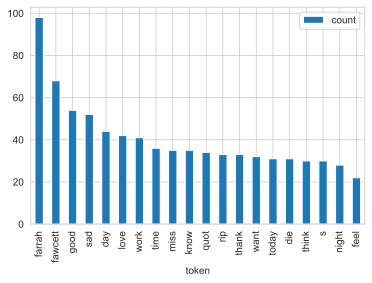

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

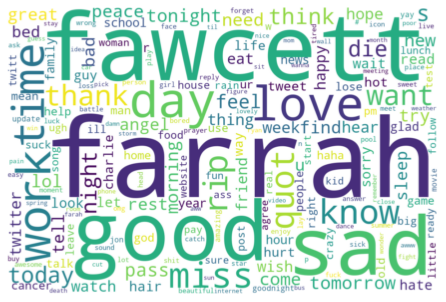

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

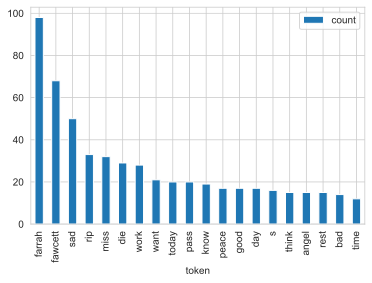

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

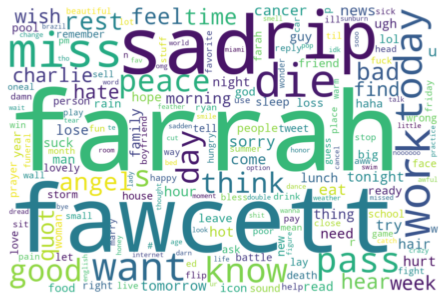

In [46]:
wordcloud(neg_counter)

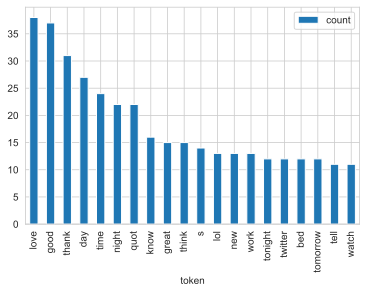

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

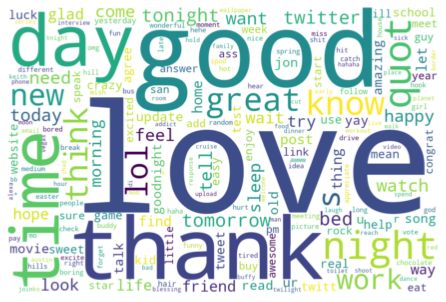

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

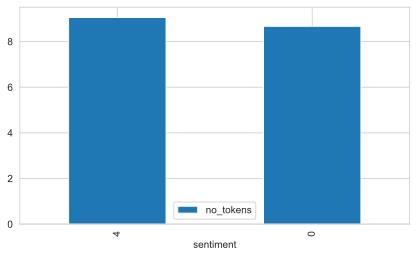

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

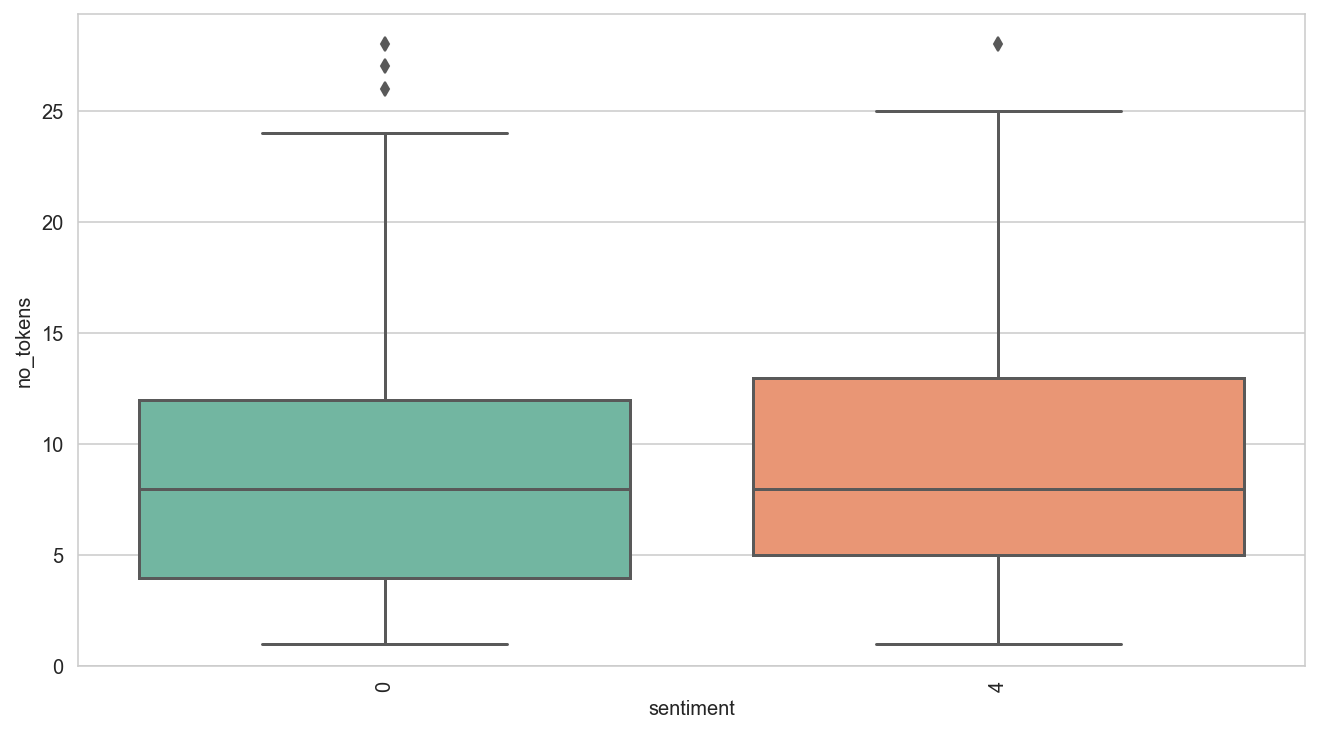

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaawwww,aaru,abay,abc,ability,able,academy,account,accountant,ace,ache,ack,ackin,acm,actress,...,yesterday,yike,ym,young,youth,youtube,you½re,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2,
        1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,age,anal,black,cancer,die,doctor,dread,face,far,farrah,fawcett,feather,get,go,grandmother,...,run,sad,shame,sky,sunny,swimming,take,think,throw,time,tissue,today,tonight,want,work
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2,1,0,0,1,0
5,0,0,0,0,0,1,1,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aaawwww farrah,aaawwww farrah ri,aaawwww farrah ri die,aaawwww farrah ri die miss,aaru hithavaru,aaru hithavaru ninage,aaru hithavaru ninage moovarolage,aaru hithavaru ninage moovarolage vote,abay sa,abay sa kasal,abay sa kasal veil,abay sa kasal veil thank,abc news,abc news die,ability quiet,...,zealand year rain,zealand year rain day,zealand year rain day india,zhen thing,zhen thing planet,zhen thing planet odd,zhen thing planet odd little,zone tweet,zone tweet morning,zone tweet morning pm,zone tweet morning pm different,zta due,zta due wks,zta due wks work,zta due wks work day
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,age grandmother,anal die,black swimming,cancer anal,cancer farrah,cancer meet,die get,die think,doctor med,dread go,face time,far want,farrah fawcett,farrah rip,farrah shame,...,sky pitch,sunny want,swimming today,take dread,throw run,time nose,time tissue,tissue far,today go,today sunny,tonight honor,want go,want rip,work ray,work today
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aaawwww,aaru,abay,abc,ability,able,academy,account,accountant,ace,ache,ack,ackin,acm,actress,...,yesterday,yike,ym,young,youth,youtube,you½re,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
788,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
789,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
790,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,age,anal,black,cancer,die,doctor,dread,face,far,farrah,fawcett,feather,get,go,grandmother,...,run,sad,shame,sky,sunny,swimming,take,think,throw,time,tissue,today,tonight,want,work
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.38,0.00,0.00,0.00,...,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.00
1,0.00,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.37,0.42,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,...,0.00,0.00,0.00,0.33,0.33,0.33,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.28,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.52,0.00,0.00,0.00,0.00,...,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.30,0.00,0.00,0.00,0.00,0.00,0.00,...,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.60,0.30,0.00,0.00,0.25,0.00
5,0.00,0.00,0.00,0.00,0.00,0.26,0.26,0.00,0.00,0.00,0.00,0.00,0.22,0.43,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.51
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.41,0.00,0.00,0.30,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.49,0.00,0.36,0.41,0.00,0.00,0.00,0.00,0.32,0.36,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  17,   18,   23,   24,   25,   26,   34,   40,   47,   48,   55,   59,
         68,   70,   78,   83,   88,   89,   92,   98,  101,  105,  121,  122,
        127,  132,  134,  138,  142,  145,  146,  156,  158,  161,  163,  175,
        177,  188,  189,  192,  193,  194,  195,  213,  215,  225,  233,  235,
        241,  242,  243,  254,  267,  270,  275,  286,  299,  303,  307,  308,
        317,  335,  341,  361,  364,  366,  374,  388,  393,  405,  413,  425,
        431,  435,  436,  437,  447,  461,  462,  467,  469,  472,  473,  474,
        483,  492,  493,  494,  496,  513,  517,  527,  536,  537,  538,  550,
        560,  564,  565,  572,  573,  574,  578,  607,  614,  628,  642,  643,
        659,  665,  670,  671,  684,  685,  686,  698,  702,  722,  730,  731,
        736,  739,  740,  750,  751,  757,  767,  772,  773,  776,  784,  787,
        794,  796,  802,  804,  806,  815,  816,  819,  820,  822,  823,  824,
        826,  839,  851,  856,  875,  880,  882,  88

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [64]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

add addict age agree ahh ahhh alexa amazing angel animal answer appreciate ask asleep attack austin awesome awful awww baby back bad battle bb beat bed beer believe beyonce big bike bless blessing blog blue border boring boy boyfriend brave brazil break breakfast buddy buffy bus buy bye can cancel cancer carry challenge charlie check chocolate class client clothe club college congrat cookie crack crappy crazy cruise cvs dad day death design di die diego different discover double doubt drag dread drink drinking drive dun easter easy eat ed enjoy entire evening excellent excite excited face family farah farrah favorite fawcett fawcetts feather flip food friday funeral funny gettin gig give glad good goodbye goodnight great grow hahaha happen happy hate hav have healthy hear hehe high hill hills hit holla home honor hook hospital hot hour hungry hurt hybrid ice icon idea idk ihad india interview ipod jill join jon jordan karma keith kid knight ko lady lame last late laugh lauren lay lazy 

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [66]:
model = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [1316  743 1141 ...  455  899   83]


In [67]:
i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

adam add addict afternoon age agree ahh ahhhh amazing amo angel animal animation answer appreciate arne aroundd asia ask asleep ass assignment attack attractive awake awesome awful awww babiiesss baby background backup bad bb be beat bed big bike blackberrys blessing blue bog bonjour boo border bored boring boy boyfriend brate brazil break breakfast brussels buddy buffy bus butt buy bye cable can cancel cancer car care carless carry ce challenge change charlie check cheer cheers chilling chilly chocolate cider class clean cleaning client cliff close clothe cold college complaint confuse congrat cookie cool could crack crappy crazy curious cvs cw dad dam damn darn day death deck di die diego different discourse discover do dollar double doubt draag drag dread dream drink drinking drive dump dun dundrum dunno easter easy eat empty endless enjoy enough enter entire evening example excite excited fabulous face fail family fan farah farrah fat favorite fawcett feel fill finish follow follow

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [68]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 0.00e+00 0.00e+00 ... 5.74e-06 0.00e+00 5.75e-04]


In [70]:
i=0
n=0
min_imp = 0.00041
min_starred = 0.004
for x in model_bagged.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

ability able ad add afraid agree ahhhh amazing angel animation annoying answer arne ask ass assignment attack awesome awful awww babiiesss back background ***bad bb be beautiful bed beef big bike blackberrys bless blessing blew bog boo bored boring boyfriend break brush brussels buddy bulky bun butt buy bye california call can cancel cancer car care caring carless caro carry cel change charlie cheer cheers chill chilly chocolate citizen clean cliff close clothe color come complaint computer congrat contest cooler could coupon craapppy crack crap crappy curse cut cw cybercommand dad dam damn dance dang darn ***day daylol deck ***die diego different dinner direct discourse dnt do dollar download drag dread drink dude dun dundrum dungeon dunno ***easy eat effin email employe ento erin essay esurance evening everyone excited eye face fail fall fan farah ***farrah favorite ***fawcett fawke fear ***feel feeling fellow find finish follower food forget forgot friday friend fritz frustrating fu

## Note that the stars ( *** ) denote features that were given much higher importances.

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [71]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([   0,    3,    7,   14,   17,   18,   23,   24,   25,   26,   27,   34,
         39,   40,   41,   44,   47,   48,   51,   54,   55,   58,   59,   64,
         68,   70,   73,   78,   83,   88,   89,   92,   94,   98,  105,  111,
        114,  117,  119,  122,  127,  130,  132,  134,  138,  142,  146,  153,
        154,  156,  158,  159,  161,  163,  168,  175,  176,  177,  183,  188,
        189,  190,  192,  193,  194,  195,  200,  207,  210,  211,  212,  213,
        229,  233,  235,  242,  243,  249,  254,  262,  267,  269,  270,  276,
        286,  291,  299,  303,  307,  308,  317,  326,  334,  335,  341,  345,
        361,  363,  364,  374,  380,  388,  389,  393,  394,  408,  413,  414,
        421,  422,  425,  430,  431,  435,  436,  437,  440,  447,  450,  456,
        462,  467,  469,  472,  473,  484,  488,  492,  493,  494,  496,  497,
        499,  500,  513,  517,  518,  527,  536,  537,  538,  550,  560,  564,
        565,  568,  572,  573,  574,  578,  607,  61

In [72]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

aaawwww abc account actress add addict age agree ahh ahhh ahhhh alexa amanda amazing american anal angel animal anne anotha answer apply appreciate aroundd ask asleep asscancer attack austin awesome awful awww awwww baby bad bah balcony barrie bash bb beat becca bed beer believe beyonce bike blackberrys blame bless blessing blew blog blue bog border bored boring bowling boy boyfriend brand brave brazil break breakfast brissa brother brussels brutha bryon buddy butler buy bye cancel cancer caring carry cel challenge change charlie cheer chocolate chubbx class client clothe club college common confuse congrat cookie cooool crack crap crappy cruise cupcakes cvs cw dad dam daylol death debby depend deposit design devunity di die diego different direct discover dnt dollar doubt drag dread drink drinking dundrum dyeing easter easy eat ed edinburgh effect effin enjoy entire ento evening excellent excite excited face family farah farrah faucett favorite fawcett fawcetts feather flip follow fol

## RFE on TF-IDF vectors 

In [73]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model_tfidf, 500)
fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [1316  743 1141 ...  455  899   83]


In [74]:
i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

able account add addict afraid age agree ahh ahhh ahhhh amanda amazing angel answer apply appreciate aroundd ask asleep ass attack awesome awful awww baby bad bah barrie bash bb be beat bed beer big bike blackberrys blame bless blessing blew blog blue bog border bored boring boy boyfriend brand brazil break breakfast brussels buddy buy bye can cancel cancer car care caring carry cat cel challenge change charlie check cheer chocolate class close clothe club college common confuse congrat cookie cooler could crack crap crappy cruise cupcakes cut cvs cw dad dam damn day daylol death debby di die diego different dnt dollar double doubt drag dread drink drinking drive dun dundrum dyeing easter easy eat ed effect effin english enjoy entire ento essay evening excellent excite excited fabulous face family fan farah farrah favorite fawcett feel flip follow food forgot friday friend friended fritz fuck fun funeral funny garmo geeke gettin gig give glad gmail go godplease good goodbye goodnight g

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [75]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 2.46e-06 0.00e+00 ... 2.33e-06 0.00e+00 2.17e-04]


In [76]:
i=0
n=0
min_imp = 0.00040
min_starred = 0.003
for x in model_bagged_tfidf.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

ability able ack add addict afraid afternoon age agree ahhhh ***amazing ***angel answer aroundd asia ask ass assignment attack attractive awesome awful awww background backup ***bad banana barrie bb ***be beautiful ***bed blackberrys blew bomb bonjour border bored boring boyfriend brazil break breakfast bring brussels buddy butt buy bye cable can cancel ***cancer car care caring carless caro cat ce cel ***change ***charlie cheer chill chocolate citizen cliff close coffee cold college come confuse congrat could crap crappy crazy curse ***cut cw cyrus dad dam ***damn dang ***day daylol ddi death deck ***die different disappointed dnt do double dread dream drink drive dun dundrum dunno ***easy eat ed email emailing endless english enjoy ento essay everyone excite excited eye face fall famous fan farah ***farrah ***favorite ***fawcett feather ***feel fellow fight find finish first flip flippin follow food forgot friday friend fritz fuck full fun funeral funny game get gettin gig girl give 

# A record and summary of 6 types of Feature Selection

## Because I WILL be dropping RFE for being too intensive.

### Running with 3000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport amazing american angel animal anne anniversary announce answer appreciate arm arrive attend awesome awful aww awww back bad battle beach beautiful bed bedtime beer believe beloved beyonce birthday blog blonde blue boo book boy boyfriend brand brave britney bro ... tomorrow tongue toooo tragic trust tt tuesday tweet twilight twin twit twitter ugh ughhh unc unfair update updates upgrade upload upset ur use vacuum vegas version voice vote wait walters want warped wat watch way wayne website welcome window wish woke woman wonderful woop work wrist wrong wtf xd xoxo yay young youth yup
#### RFE with Bag of Words
aargh account add addict address afraid age agree ahhh air airport album amazing angel anniversary answer app arm arrive artistic attack attend attention awesome awful awsome aww baby back bad bag battle bc beach bed bet big birthday bit blib blog blue bonjour boo bore bored boy boyfriend brain brand break ... tragic true trust tuesday tv tweeting twin twit twitter ugh unc understand unfair updates upgrade upload upset vacation vegas version vibe video vote wait walmart wanna want wat watch way wayne welcome whole whyyyy wife win wish woke wonder wonderful woop word work working world write wrong wtf xavier xd yay young yup
#### Extra Trees Forest with Bag of Words
able account add addict afraid age agree ahhhh air album alex amazing angel apettite arm art audrey awesome awful aww baby back bad bag battle bc be beach beautiful bed begin beloved big bit blaaaaarg blache blog boo bore boy boyfriend break bubba bug burn bus bye call can cancel cancer car care cat cause ... twitter ugh ughh uncle unfair unusual upgrade upgradeable upload upset upsetting ur use vacation vibe vote wait wake walk wanna want warm warning watch way weather wee week weekend welcome well wholee will wish wishing woke woman wonderful work working world would wrong xoxo yay yeanot year yesterday young yup zoo
#### SelectKBest with TF-IDF
account actress add adore age agree ahaha ahhh airport amazing american anal angel anne anniversary announce annoying answer apologize appreciate arm arrive attend awesome awful awsome aww back background bad bag battle beach beautiful beauty bed bedtime beer beie believe beloved bestie beyonce birthday ... touchy tragic trust tuesday tweetie twilight twin twit twitt twitter ugh ughhh unc uncle understand unfair updates upload upset upsetting use va vegas version view voice vote wait wallpaper want watch way website welcome westney window wish woke woman wonderful woo work wrong xd xoxo yay yayyy young youth yup zoo 
#### RFE with TF-IDF
able account add address afraid age agree ahhh airport album amazing american angel anne anniversary answer appreciate arm arrive art attention awesome awful awsome aww back background bad bag battle bc be beach bed believe big birthday bit blog blue bonjour boo book bore bout boy boyfriend brand brb break bro ... upsetting va vacation vegas version vibe vote wait walk wanna want watch way wee welcome whole window wish wishing woke wonder wonderful word work working world wrong wtf xoxo yay young yud yup zoo
#### Extra Trees Forest with TF-IDF
able actress add addict afraid age agree ahhhh airport alex amazing andrewcilley angel apettite arm art awesome awful aww baby back bad battle bc be beach beautiful bed believe beloved big bit blaaaaarg blache blackberrys blog boo book bore bowls boy boyfriend break brussels bubba bug bunny burn butterfly ... upgrade upgradeable upload upset upsetting ur use vacation vegas vibe video wait wake walk walmart wanna want warm warning watch way weather wee week weekend welcome well whole wholee will window wish wishing woke woman wonderful word work working world worried would wrong xoxo yay yeanot year yesterday young yud yup yuri zoo  



## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [77]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector_ngrams = SelectKBest(chi2, k=400)
selected_features_ngrams = \
ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_ngrams

array([   65,    66,    67,    68,   212,   245,   527,   562,   592,   656,
        1162,  1175,  1178,  1309,  1917,  1974,  2006,  2143,  2158,  2427,
        2694,  2695,  2745,  2762,  2778,  2779,  2780,  2791,  2798,  2799,
        2812,  2813,  2828,  2846,  2859,  2863,  2871,  2890,  2898,  2946,
        2950,  2956,  2994,  2995,  3011,  3021,  3022,  3044,  3045,  3062,
        3096,  3113,  3117,  3126,  3141,  3153,  3250,  3253,  3435,  3637,
        3644,  3752,  3771,  3778,  3817,  3866,  3891,  3907,  3946,  4047,
        4126,  4399,  4601,  4883,  4884,  4929,  5179,  5272,  5475,  5476,
        5780,  5794,  5802,  5828,  5947,  6489,  6814,  7214,  7222,  7249,
        7253,  7254,  7255,  7256,  7267,  7652,  7656,  7657,  8095,  8096,
        8097,  8167,  8269,  8290,  8302,  8312,  8313,  8314,  8320,  8336,
        8342,  8348,  8377,  8409,  8444,  8501,  8578,  8941,  8974,  9086,
        9635,  9636,  9637,  9701,  9851,  9958,  9959,  9960,  9961,  9969,

In [78]:
for x in selected_features_ngrams:
    print(vocab_ngrams[x], end=' -       - ')

afternoon thank -       - afternoon thank leaving -       - afternoon thank leaving sad -       - afternoon thank leaving sad theresa -       - angel sad -       - answer find -       - battle cancer -       - be be -       - be need -       - bed night -       - can believe -       - can wait -       - can wait see -       - charlie angel -       - day day -       - day sad -       - day sun -       - die miss -       - die think -       - ed mcmahon -       - family friend -       - family friend sad -       - farah fawcett -       - farrah charlie -       - farrah fawcett -       - farrah fawcett battle -       - farrah fawcett battle cancer -       - farrah fawcett cancer -       - farrah fawcett charlie -       - farrah fawcett charlie angel -       - farrah fawcett find -       - farrah fawcett find die -       - farrah fawcett hear -       - farrah fawcett morning -       - farrah fawcett pass -       - farrah fawcett rest -       - farrah fawcett sad -       - farrah fawcett wo

write tell speak -       - write tell speak suck -       - write tell speak suck get -       - wrong try -       - wrong try care -       - www facesbyrozzj -       - www facesbyrozzj com -       - www facesbyrozzj com follow -       - xd awesome -       - xd awesome next -       - xd awesome next read -       - xd awesome next read know -       - xd find -       - xd find love -       - xxxx love -       - xxxx love can -       - xxxx love can beaten -       - xxxx love can beaten bus -       - yay ass -       - yay ass stalk -       - yay ass stalk sexy -       - yay ass stalk sexy get -       - yay cuddle -       - yay cuddle buddy -       - yay cuddle buddy new -       - yay cuddle buddy new find -       - yay hehe -       - yay hehe twin -       - yay love -       - yay love boxnet -       - yay love boxnet business -       - yay love boxnet business partner -       - yay night -       - yay night homework -       - yay night homework stay -       - yayyy lol -       - yayyy lol h

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand vectors with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 3000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

In [79]:
model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

[0. 0. 0. ... 0. 0. 0.]


In [80]:
i=0
n=0
min_imp = 0.00041
min_hilite = 0.0028
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        if x>min_hilite:
            print('|||--', end="")
            print(vocab_ngrams[i], end='--||| -       - ')
        else:
            print(vocab_ngrams[i], end=' -       - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

actress favorite -       - ad sound flag -       - afraid nasty be -       - |||--ahhhh fall--||| -       - ai yrs leav -       - angel good -       - angel sad -       - aroundd good lay -       - awful little -       - |||--aww sad--||| -       - aww thank -       - babysitting fair -       - bad lay rain suck -       - bad oooow stop hurt -       - bad sure -       - bah pass -       - balcony hawaii -       - balcony hawaii miss -       - barrie bad -       - barrie bad sure come -       - battle cancer -       - bbz farrah -       - be be -       - |||--be loner--||| -       - be need -       - bed night -       - |||--blackberrys fritz--||| -       - blew tire -       - bog twitter -       - boo hoo carless -       - |||--boyfriend miss--||| -       - bring catch -       - bunny coupon -       - call come -       - can believe -       - can leave -       - |||--can wait--||| -       - can wait see -       - candid steph see verify get -       - |||--car overheated--||| -       - 

person beautiful rip -       - phone can leave -       - pics bog -       - pics bog twitter -       - picture sweet -       - plain jane -       - plain jane wrong -       - planning think -       - pleaase call come -       - poker first round -       - pool today -       - |||--power cut--||| -       - prague gig tip -       - pray problem -       - pray problem tell -       - prayer family -       - prayer family friend -       - prayer family friend sad -       - pressure eye essay leave -       - pressure eye essay leave go -       - problem tell -       - quot bad -       - quotwreck journal quot bad -       - rachel say -       - |||--read tweet--||| -       - reading manga -       - ready make -       - reply say -       - rest day -       - return young -       - right hungry -       - right hungry be -       - rip hope -       - rip jill -       - rip jill monroe -       - rip miss -       - ripfarrahfawcett angel good -       - rival ad sound -       - rival ad sound flag -

# Milestone 1 - Conclusion

### Data has been loaded, cleaned, saved, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.


Dec 14 2019

# Beginning of Milestone 2

Working models.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_sm['text_nav'], df_sm['sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [89]:
print(clf.predict(count_vect.transform(["AArgh, this is the silliest thing ever"])))

[0]


In [90]:
print(clf.predict(count_vect.transform(["I absolutely love this code."])))

[4]


In [91]:
print(clf.predict(count_vect.transform(["Not sure what I think of this one."])))

[4]


In [132]:
print(clf.predict(count_vect.transform(["Why would you do that?"])))

[0]


In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tv_matrix, df_sm['sentiment'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

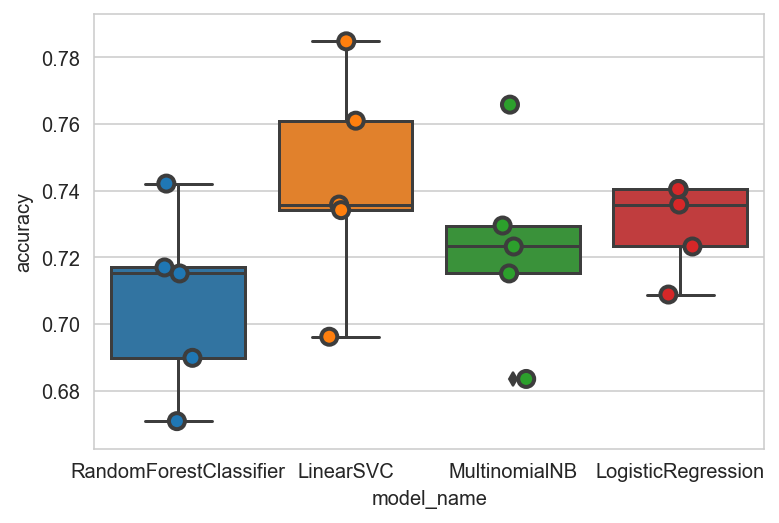

In [110]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [111]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                0.74
LogisticRegression       0.73
MultinomialNB            0.72
RandomForestClassifier   0.71
Name: accuracy, dtype: float64

In [112]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tv_matrix, df_sm['sentiment'], df_sm.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion Matrix

Calculate, and display, true positives, true negatives, false positives, and false negatives.

We'll show both the raw matrix, and a "Heatmap", which looks cool, but doesn't give too much insight with only two labels.

RAW CONFUSION MATRIX
[[ 86  51]
 [ 15 110]]
Because the heatmap may LOOK cool, but doesn't tell us much, with only two labels
--------------------
Heatmap of Consfusion Matrix:


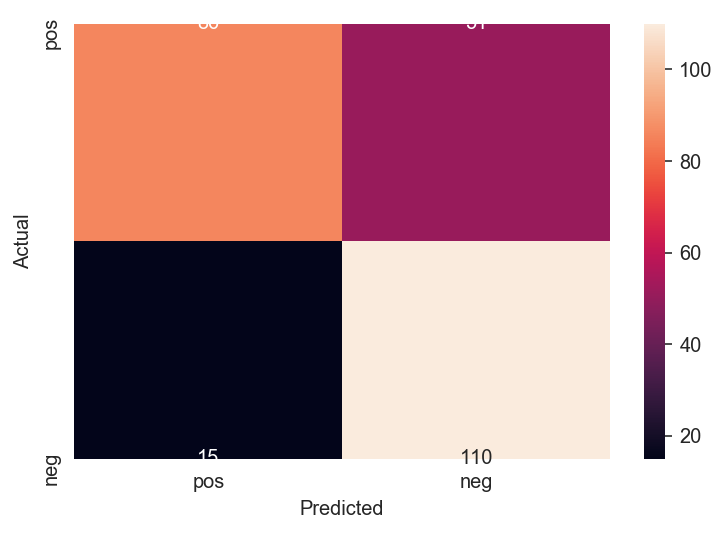

In [126]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX')
print(conf_mat)
print('Because the heatmap may LOOK cool, but doesn\'t tell us much, with only two labels')
print('--------------------')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [127]:
model.fit(tv_matrix, df_sm['sentiment'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Precision, Recall and f1-Score

In [130]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72       137
           4       0.68      0.88      0.77       125

    accuracy                           0.75       262
   macro avg       0.77      0.75      0.75       262
weighted avg       0.77      0.75      0.74       262



## Interesting points of comparison!!

Early in this project, I was doing sentiment predictions with Afinn, to be used as a baseline later. At our first arrival at this point, things are looking better already!

#### Weighted Avg F1-Scores
-----------------------------------

0.63 - Afinn original values.

0.74 - 800 rows, Tf-idf encoding, NO feature selection, Linear SVC


# ============================

# Ensembling

# ============================

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: sequential ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and parallel ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight. The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to homogeneous ensembles. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to heterogeneous ensembles. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.

### Bagging

Bagging stands for <b>bootstrap aggregation</b>. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:

\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

<b>Translation:</b> <i><u>The final result is the average of the M sub-results.</u></i>

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [133]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [134]:
# X, y = iris.data[:, 0:2], iris.target

X = tv_matrix
y = np.array(df_sm['sentiment'])
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.62 (+/- 0.01) [Decision Tree]
Accuracy: 0.65 (+/- 0.03) [K-NN]
Accuracy: 0.62 (+/- 0.01) [Bagging Tree]
Accuracy: 0.60 (+/- 0.04) [Bagging K-NN]


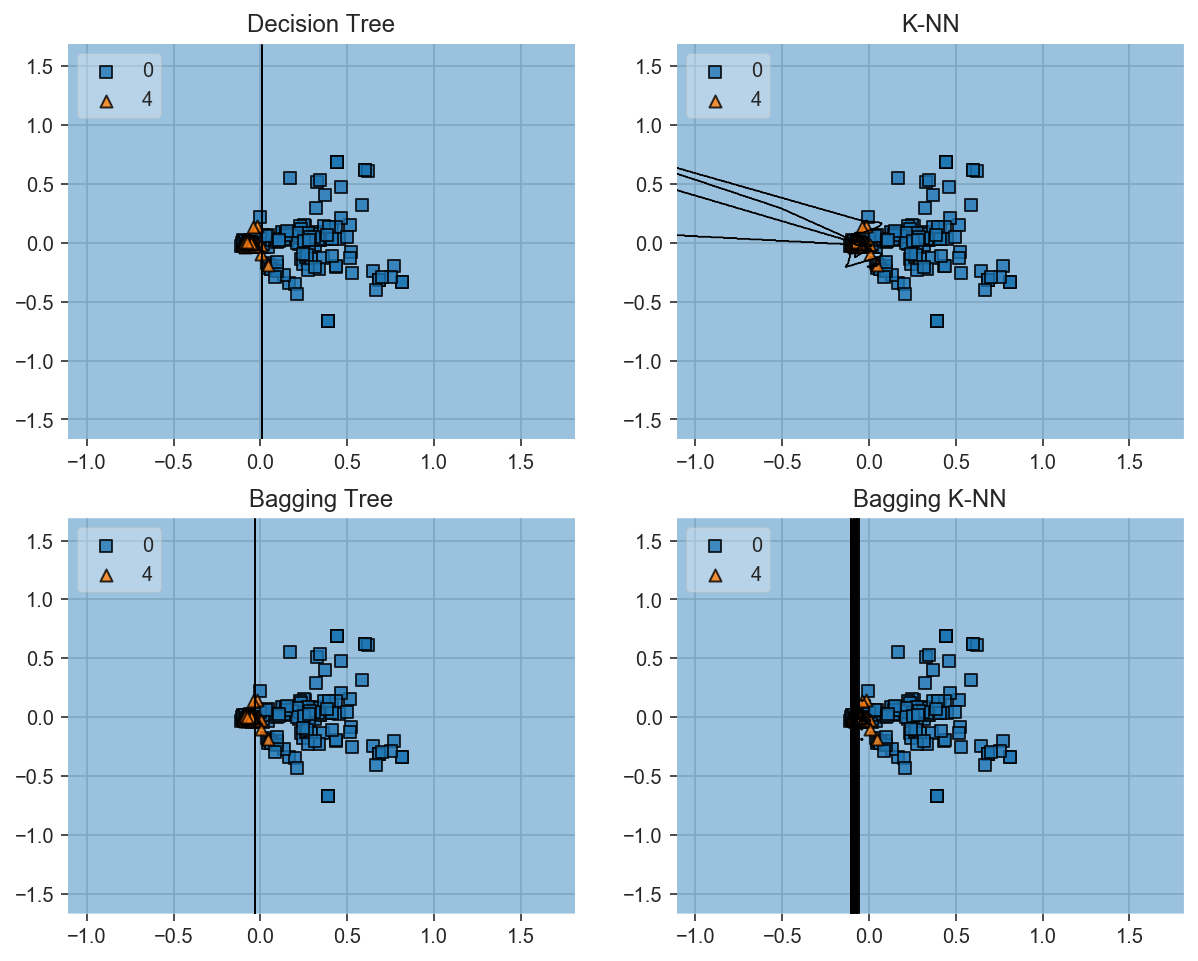

In [145]:
from sklearn.decomposition import PCA

label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    #clf.fit(X, y)
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    #clf.fit(X_flattened, y)
    #clf.fit(X, y)
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf, legend=2)
    plt.title(label)
    

    #plot_decision_regions(X_train2, y_train, clf=clf, legend=2)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

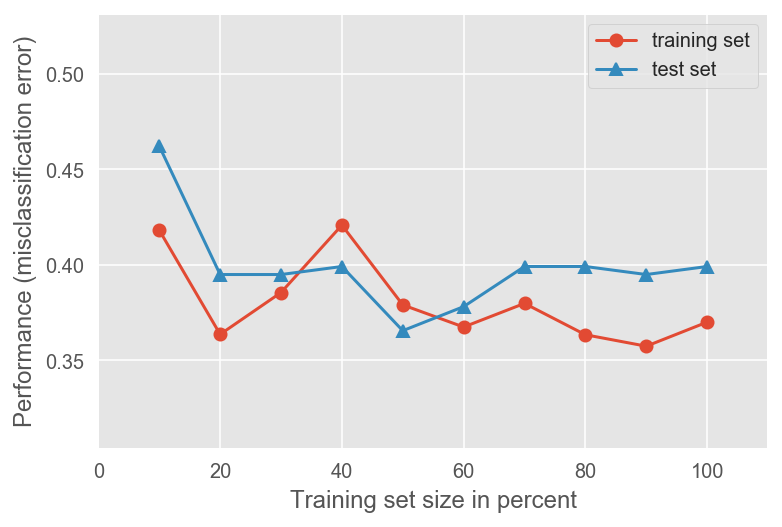

In [146]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of  0.35  on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around  80%  of the training set size.

In [147]:
#Ensemble Size
# num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

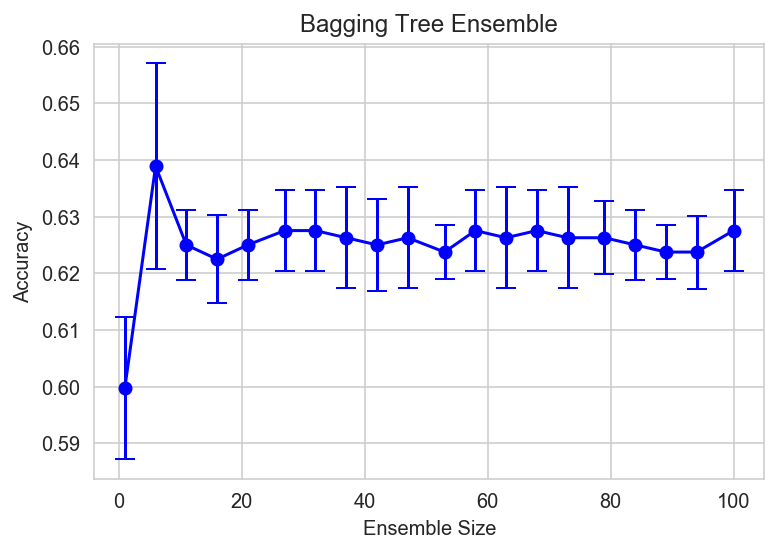

In [148]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
# caps = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $10$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $10$ only increases computational complexity without accuracy gains for the Sentiment140 dataset.

----------------------

## Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.

In [149]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [168]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [169]:
len(X)

792

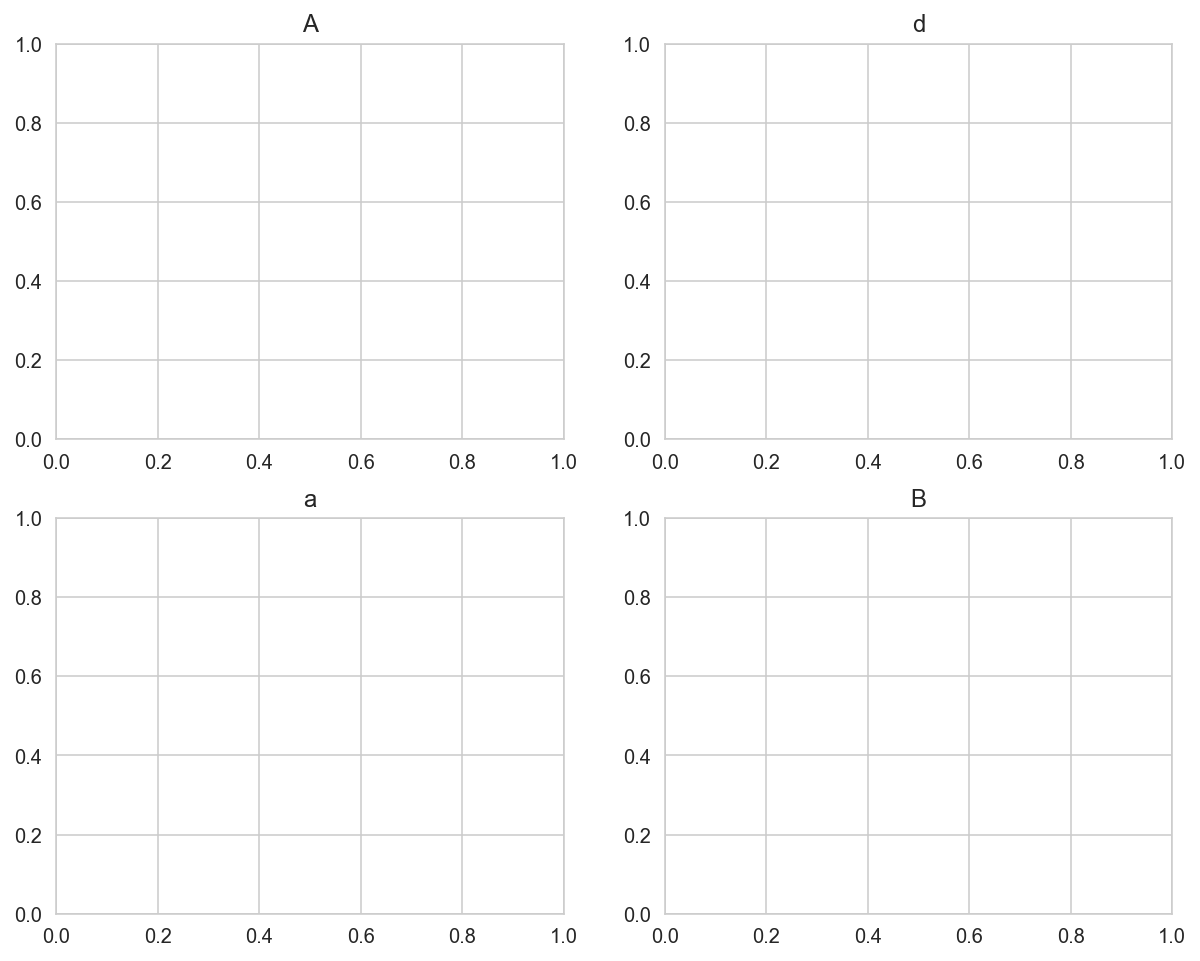

In [171]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    #pca = PCA(n_components = 2)
    #X_flattened = pca.fit_transform(X)
    boosting.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    #fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

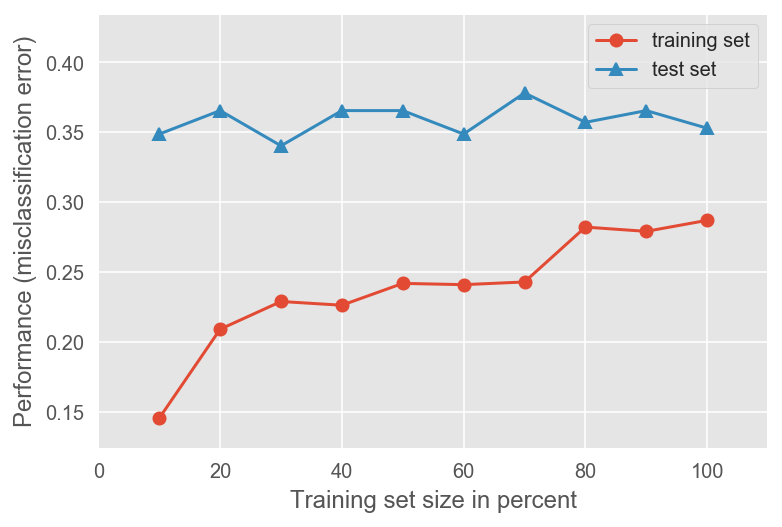

In [172]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [173]:
#Ensemble Size
#num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,100,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

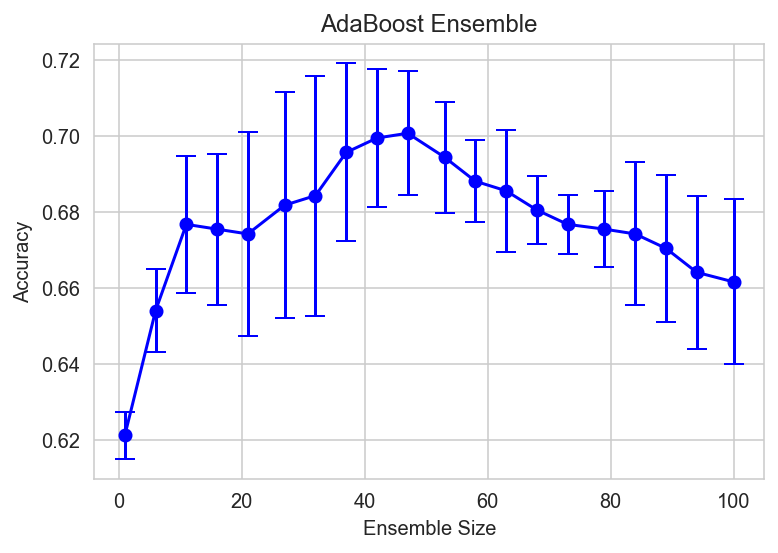

In [174]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

----------------

## Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [175]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [176]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

Accuracy: 0.60 (+/- 0.04) [KNN]
Accuracy: 0.62 (+/- 0.02) [Random Forest]
Accuracy: 0.67 (+/- 0.01) [Naive Bayes]
Accuracy: 0.60 (+/- 0.03) [Stacking Classifier]


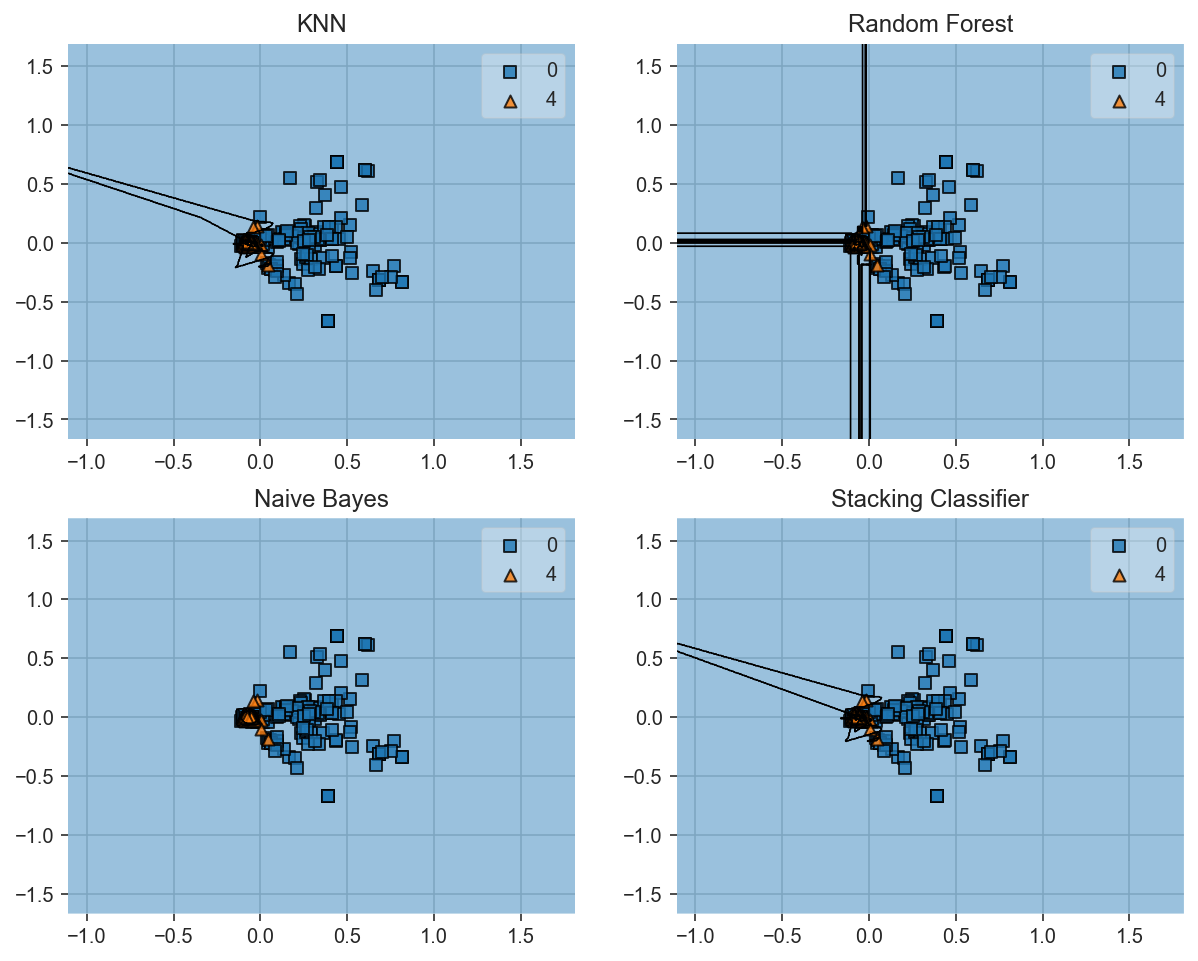

In [178]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
        
    scores = cross_val_score(clf, X_flattened, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf)
    plt.title(label)

plt.show()

The stacking ensemble is illustrated in the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

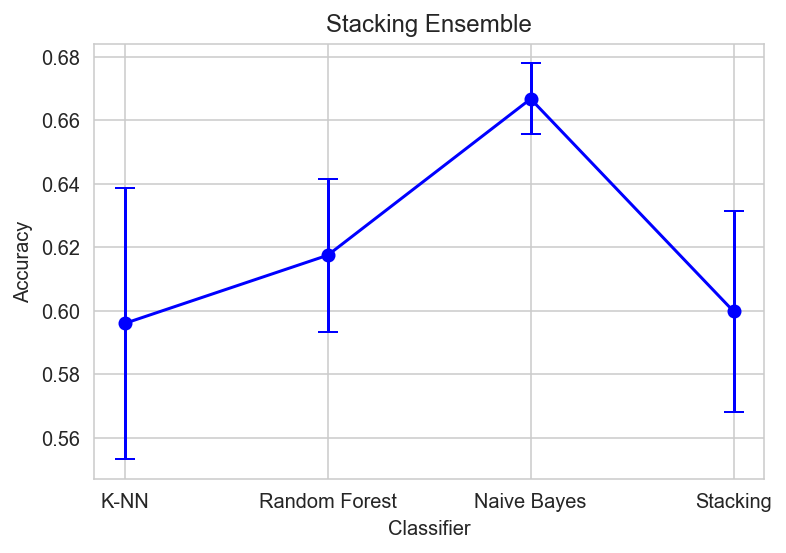

In [181]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['K-NN', 'Random Forest', 'Naive Bayes', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

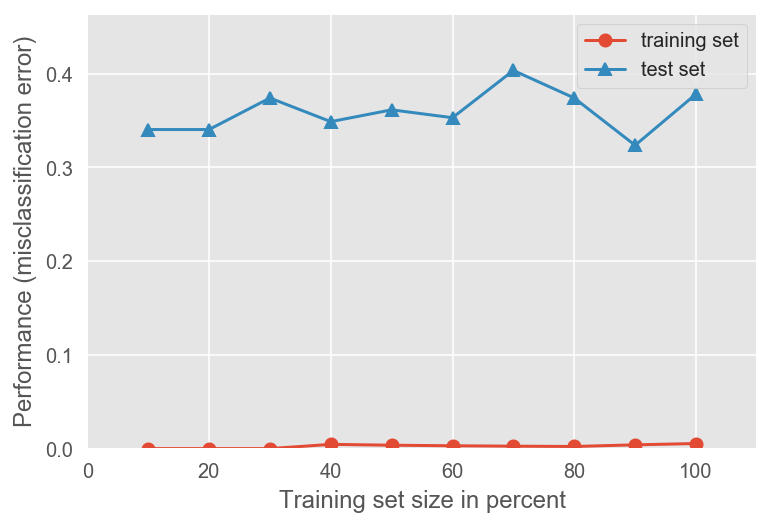

In [182]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [81]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [82]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [83]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

In [84]:
# Predict sentiment with Afinn

#sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
#predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [85]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
#                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [86]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
799599,0,2329056794,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,enge10,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,GUYS the ghost is back at my house. wreaking havoc in the living room at odd hours of the night. cleaning up,guys ghost back house wreaking havoc living room odd hours night cleaning,guy ghost back house wreak havoc live room odd hour night cleaning,guy house havoc room hour night cleaning,odd,ghost wreak live,guy house havoc room hour night cleaning odd ghost wreak live,12
799600,0,2329056832,Thu Jun 25 10:17:56 PDT 2009,NO_QUERY,alysamarsiella,RIP Farrah what a shame. I may feather my hair tonight in your honor.,RIP Farrah what a shame. I may feather my hair tonight in your honor.,rip farrah shame may feather hair tonight honor,rip farrah shame may feather hair tonight honor,farrah shame hair tonight honor,,rip may feather,farrah shame hair tonight honor rip may feather,8
799601,0,2329056954,Thu Jun 25 10:17:57 PDT 2009,NO_QUERY,velobabe,RIP Farrah Fawcett http://www.cnn.com/2009/SHOWBIZ/TV/06/25/obit.fawcett/index.html More losses to cancer,RIP Farrah Fawcett More losses to cancer,rip farrah fawcett losses cancer,rip farrah fawcett loss cancer,fawcett loss cancer,farrah,rip,fawcett loss cancer farrah rip,5
799602,0,2329057090,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,XoAngelJenn36oX,"it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!","it was so nice and sunny this morning, and now the sky is like pitch black i wanted to go swimming today!",nice sunny morning sky like pitch black wanted go swimming today,nice sunny morning sky like pitch black want go swimming today,nice morning sky pitch black swimming today,sunny,want go,nice morning sky pitch black swimming today sunny want go,11
799603,0,2329057145,Thu Jun 25 10:17:58 PDT 2009,NO_QUERY,OliviaDAngelo,So sad about Farrah Fawcett...,So sad about Farrah Fawcett...,sad farrah fawcett .,sad farrah fawcett .,farrah fawcett,sad,,farrah fawcett sad,4


## Save to database

In [87]:
#df.to_sql('df_sm', con)